In [1]:
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import sys, os, yaml
import pickle
import inspect
from omegaconf import omegaconf

def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]
sys.path.append("/home/")
fig_folder = os.path.join(os.sep, "home", "smoke", "artifacts")
import tqdm
run_id_yaml = "artifacts/mlflow_run_id.yaml"
run_id = "a5fc860be53d48c9ac1573b75f1cba8f"

/opt/conda/lib/python3.10/site-packages/pydantic/_internal/_fields.py:127: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pydantic/_internal/_config.py:269: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [2]:
def bmm(a, b):
    return np.einsum("Bij,Bjk ->Bik", a, b)


def bt(a):
    return np.einsum("Bij->Bji", a)


def bouter(a, b):
    return np.einsum("Bnr,Bnr -> Bnn", a, b)


def bouter1D(a, b):
    return np.einsum("Bi,Bj -> Bij", a, b)


def bqr(a):
    Q = np.empty_like(a)
    for i, mat in enumerate(a):
        Q[i, ...] = np.linalg.qr(mat)[0]
    return Q

def printshape(*args):
    for el in args:
        try:
            print(f"{retrieve_name(el)}.shape={el.shape}")
        except e:
            pass

In [3]:
A_ = np.random.normal(size = (5, 20, 20))
A = bmm(bt(A_), A_)
np.linalg.slogdet(A)

(array([1., 1., 1., 1., 1.]),
 array([40.59656717, 36.93415711, 43.26061431, 39.37718832, 31.31874236]))

In [4]:
weights_, vectors_ = np.linalg.eigh(A)
weights, vectors = weights_[:, :]+1.0, vectors_[:, :, :]

In [5]:
weights.shape, vectors.shape
np.isclose((A - bmm(vectors, weights[:, :, None] * bt(vectors))), 0).all()

False

In [6]:
def low_rank_construction(Ur, Sr):
    return bmm(Ur, Sr[:, :, None] * bt(Ur))

def identity_batch(state_dimension, nbatch):
    return np.tile(np.eye(state_dimension), (nbatch, 1, 1))

id_batch = identity_batch(5, 3)

In [7]:

def power_singular_value_reconstructon(Ur, Sr, alpha):
    batch_size, state_dimension, rk = Ur.shape
    identity = identity_batch(state_dimension, batch_size)
    return identity + low_rank_construction(Ur, Sr ** (alpha) - 1)


low_rank_construction(vectors, weights)

array([[[ 1.25292761e+01,  1.49829547e+00,  9.33093055e+00, ...,
          4.81463421e+00, -1.21317935e+01, -1.22498728e+00],
        [ 1.49829547e+00,  2.80153681e+01, -2.85459627e+00, ...,
          9.04253527e-01, -8.80649487e+00,  2.93837908e+00],
        [ 9.33093055e+00, -2.85459627e+00,  2.83677832e+01, ...,
          2.39508080e+00, -1.23864030e+01, -2.26810199e+00],
        ...,
        [ 4.81463421e+00,  9.04253527e-01,  2.39508080e+00, ...,
          2.32676691e+01, -1.04871163e+01, -1.09094831e+00],
        [-1.21317935e+01, -8.80649487e+00, -1.23864030e+01, ...,
         -1.04871163e+01,  2.65605761e+01,  1.97730894e+00],
        [-1.22498728e+00,  2.93837908e+00, -2.26810199e+00, ...,
         -1.09094831e+00,  1.97730894e+00,  1.23969177e+01]],

       [[ 2.85645599e+01, -2.81235599e+00, -1.53096925e+01, ...,
         -1.12992370e+01,  5.10473653e-01, -4.41811207e+00],
        [-2.81235599e+00,  1.85416353e+01,  9.97164137e+00, ...,
         -3.12902251e+00, -1.54172874e

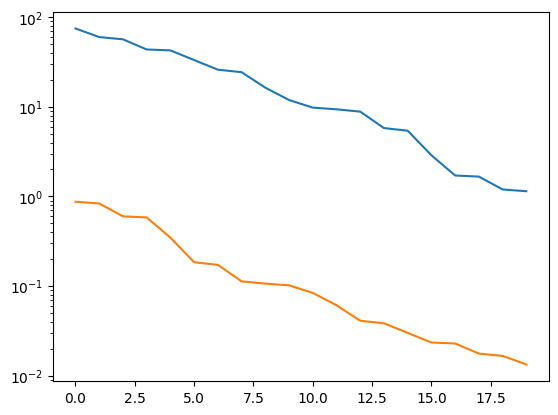

In [8]:
plt.plot(np.linalg.svd(power_singular_value_reconstructon(vectors, weights, 1)[0], compute_uv=False))
plt.plot(np.linalg.svd(power_singular_value_reconstructon(vectors, weights, -1)[0], compute_uv=False))
plt.yscale('log')

In [9]:
# with open(run_id_yaml, "r") as fstream:
#     run_id_yaml = yaml.safe_load(fstream)
#     # run_id = run_id_yaml["run_id"]
#     data_path = run_id_yaml["data_path"]
data_path = "/root/raw_data/data_100_large/"
run_id= "08a8e575b1394c3588848cd2f947c0c0"

In [11]:
from omegaconf import OmegaConf
import sys
sys.path.append('..')
from prec_models.models_spectral import SVDConvolutional
from prec_models import construct_model_class
import torch

In [12]:
run_id = OmegaConf.load('artifacts/mlflow_run_id.yaml')
model_path = run_id['model_path']
config = OmegaConf.load(os.path.join(os.sep, *model_path.split('/')[:-1], 'config.yaml'))
print(model_path)
print(config)
sys.path.append('..')
model_list = [SVDConvolutional]
model_classes = {cl.__name__: cl for cl in model_list}


/data/data_data_assimilation/lorenz/tmp_model_storage/3c49c47492ef4b54a1431d661b89ea71/model.pth
{'model': {'dimension': 100, 'window': 10}, 'data': {'data_folder': '/data/data_data_assimilation/data_100_large', 'nsamples': 20000}, 'architecture': {'class': 'SVDConvolutional', 'rank': 95, 'n_layers': 4, 'neurons_per_layer': 0, 'batch_size': 8, 'lr': 1e-05, 'n_rnd_vectors': 0}, 'optimizer': {'epochs': 50}, 'DA': {'n_cycle': 10, 'n_outer': 5, 'n_inner': 100, 'model_error_sqrt': 0.5, 'obs_error_sqrt': 3.0, 'log_file': '/GNlearning/lorenz/artifacts/DA_logs.csv'}, 'misc': {'mlflow': True}}


In [13]:
torch_model = construct_model_class(
    model_classes[config["architecture"]["class"]],
    rank=config["architecture"]["rank"],
)
state_dimension = config["model"]["dimension"]
loaded_model = torch_model(state_dimension=state_dimension, config=config["architecture"])
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

dummy(
  (layers): ConvLayersSVD(
    (dilations_layers): ParallelConv1DDilations(
      (conv_layers_dilations): ModuleList(
        (0): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
        (1): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=(4,), dilation=(2,), bias=False, padding_mode=circular)
        (2): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=(8,), dilation=(4,), bias=False, padding_mode=circular)
      )
    )
    (convlayers_vec): PeriodicConv1DBlock(
      (layers_vec): Sequential(
        (0): Conv1d(4, 95, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
        (1): BatchNorm1d(95, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Conv1d(95, 95, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
        (4): BatchNorm1d(95, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Lea

In [15]:
logged_model = f"runs:/{run_id}/smoke_model"
# mlflow.pyfunc.get_model_dependencies(logged_model)
loaded_model = mlflow.pyfunc.load_model(logged_model)
print(f"{loaded_model=}")


MlflowException: Run '3c49c47492ef4b54a1431d661b89ea71' not found

In [ ]:
# with open(data_path, "rb") as handle:
#     data = pickle.load(handle)
# x_, fo_, tlm_ = zip(*data)
x_mmap = "/data/data_data_assimilation/data_100_large/x.memmap"
tlm_mmap = "/data/data_data_assimilation/data_100_large/tlm.memmap"
nsamples=20000
dim = 100
window= 10
x_ = np.memmap(
    x_mmap,
    dtype="float32",
    mode="c",
    shape=(nsamples, dim),
)
tlm_ = np.memmap(
    tlm_mmap,
    dtype="float32",
    mode="c",
    shape=(nsamples, dim * window, dim),
)
# x_ = np.asarray(x_)

In [ ]:
def construct_svd_ML(loaded_model, x_):
    pred = loaded_model.forward(torch.tensor(np.asarray(x_).astype("f"))).detach().numpy()
    Ur, logsvals = pred[:, :-1, :], pred[:, -1, :]
    Sr = np.exp(logsvals)
    Ur = bqr(Ur)
    # proj = bmm(qi, (inv_sv[..., None] * bt(qi)))
    return Sr.squeeze(), Ur.squeeze()


In [ ]:
x_dummy = torch.tensor(np.asarray(x_).astype("f"))[:5, :]

In [ ]:
# torch.jit.trace(loaded_model, (x_dummy))
scr = loaded_model.to_torchscript(method="trace", example_inputs=x_dummy)
torch.jit.save(scr, "model.pt")

In [ ]:
scripted = torch.jit.load('model.pt')

In [ ]:
scripted(x_dummy).shape

torch.Size([5, 101, 95])

In [ ]:
svds = construct_svd_ML(loaded_model, x_)

In [ ]:
tlm_[0].shape

(1000, 100)

In [ ]:
Sr = svds[0]
Ur = svds[1]

In [ ]:
Sr.shape

(20000, 95)

 ...]

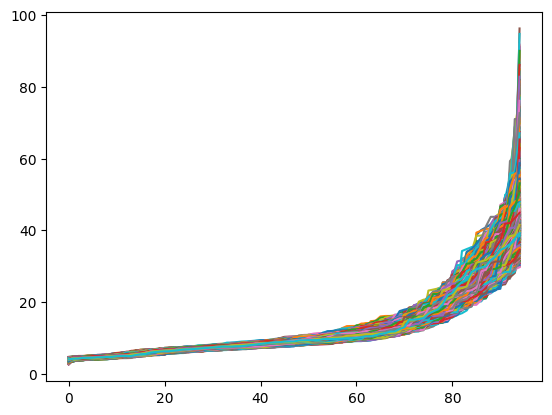

In [ ]:
plt.plot(np.sort(Sr)[::-1].T)

In [ ]:
idx = 0
U_ex = Ur[idx, ...]
S_ex = Sr[idx]
A_t = tlm_[idx].T @ tlm_[idx]
A_re = U_ex @ (S_ex * U_ex).T
U_t, S_t, _ = np.linalg.svd(A_t) #U_t @ (S_t * U_t).T == A_t
printshape(U_ex, S_ex, A_t, A_re, U_t, S_t)
pinv_re = U_ex @ (S_ex**(-1) * U_ex).T

U_ex.shape=(100, 95)
S_ex.shape=(95,)
A_t.shape=(100, 100)
A_re.shape=(100, 100)
U_t.shape=(100, 100)
S_t.shape=(100,)


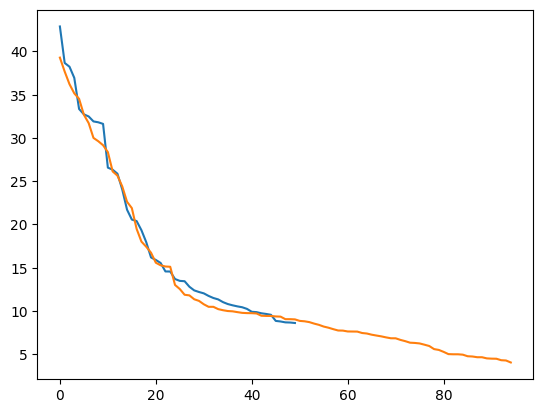

In [ ]:
plt.plot(np.linalg.svd(A_t, compute_uv=False)[:50])
plt.plot(np.sort(S_ex)[::-1], label='svd(A) ML')


14.197993
11.365421009791444
5.7930545495211545


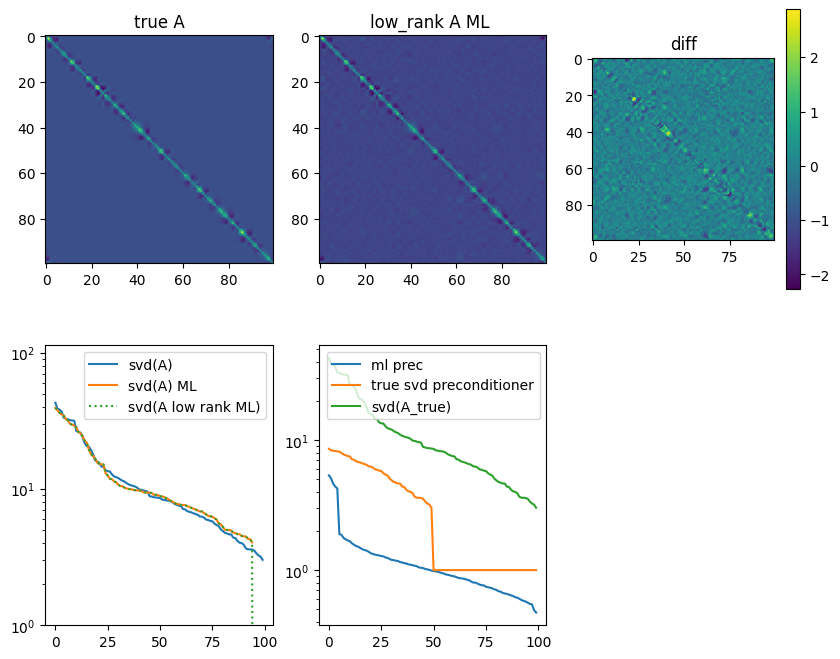

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 3, 1)
plt.imshow(A_t)
plt.title('true A')
plt.subplot(2, 3, 2)
plt.imshow(A_re)
plt.title('low_rank A ML ')
plt.subplot(2, 3, 3)
plt.imshow(A_t - A_re)
plt.title('diff')
plt.colorbar()
plt.subplot(2, 3, 4)
plt.plot(np.linalg.svd(A_t, compute_uv=False), label='svd(A)')
plt.plot(np.sort(S_ex)[::-1], label='svd(A) ML')
plt.plot(np.linalg.svd(A_re, compute_uv=False), ':', label="svd(A low rank ML)")
plt.legend()
plt.yscale('log')
plt.ylim(bottom=1)
plt.subplot(2, 3, 5)
plt.plot(np.linalg.svd((np.eye(100) + U_ex @ ((S_ex**(-1) - 1) * U_ex).T) @ A_t, compute_uv=False), label='ml prec')
plt.plot(np.linalg.svd((np.eye(100) + U_t[..., :50] @ ((S_t[..., :50]**(-1) - 1) * U_t[..., :50]).T) @ A_t, compute_uv=False), label='true svd preconditioner')
plt.plot(np.linalg.svd(A_t, compute_uv=False), label='svd(A_true)')
plt.yscale("log")
plt.legend()
prec_A = (np.eye(100) + U_ex @ ((S_ex**(-1) - 1) * U_ex).T) @ A_t
prec_A_t = (np.eye(100) + U_t[..., :75] @ ((S_t[..., :75]**(-1) - 1) * U_t[..., :75]).T) @ A_t
print(np.linalg.cond(A_t))
print(np.linalg.cond(prec_A))
print(np.linalg.cond(prec_A_t))

In [ ]:
sort_idx = np.argsort(S_ex)[::-1]
U_ex = U_ex[:, sort_idx]


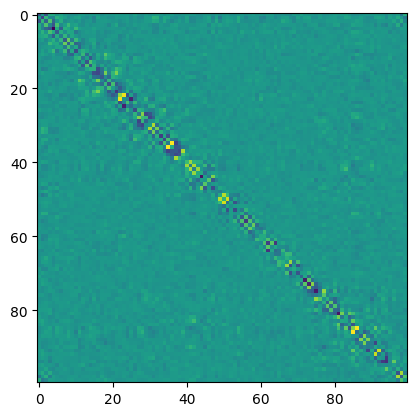

In [ ]:
plt.imshow(A_t @ pinv_re @ A_t - A_t)


In [ ]:
def inverse_iteration(A, b0, mu):
    def_A = A - mu * np.eye(A.shape[0])
    b1 = np.linalg.solve(def_A, b0)
    return b1 / np.linalg.norm(b1)

def inverse_iteration_alg(A, b0, mu, niters=5):
    b_new = b0
    for i in range(niters):
        b_new = inverse_iteration(A, b_new, mu)
    return b_new

In [ ]:
new_U = inverse_iteration_alg(A_t, U_ex[..., 0], S_ex[0], 2)

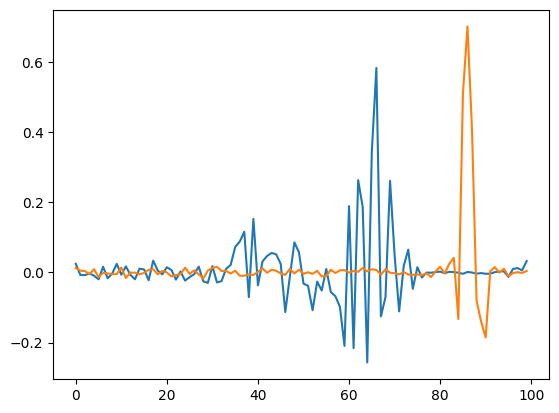

In [ ]:
plt.plot(new_U)
plt.plot(U_ex[..., 0])

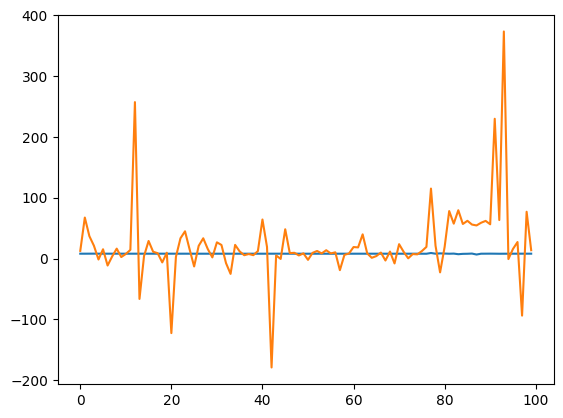

In [ ]:
plt.plot((A_t @ new_U) / new_U)
plt.plot((A_t @ U_ex[..., 0]) / U_ex[..., 0])

In [ ]:
from DA_PoC.common.linalg import randomised_eigval_decomposition


In [ ]:
W, V = randomised_eigval_decomposition(A_t, 75, 2)
print(W.shape, V.shape)

(75,) (100, 75)


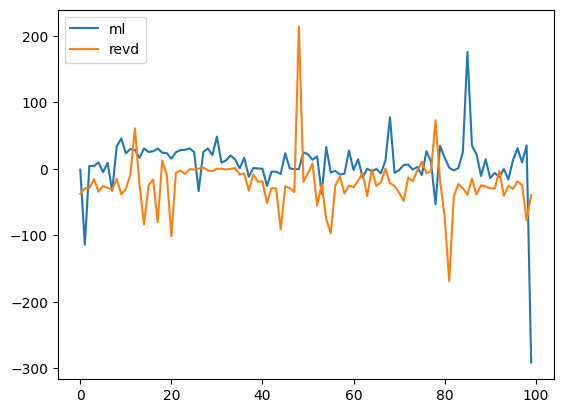

In [ ]:
idx = 5
plt.plot((A_t @ U_ex[:, idx] / U_ex[:, idx]) - S_ex[idx], label='ml')
plt.plot((A_t @ V[:, idx] / V[:, idx]) - W[idx], label='revd')
plt.legend()


In [ ]:
err = []
for idx in range(75):
    err_ml = np.mean(((A_t @ U_ex[:, idx] / U_ex[:, idx]) - S_ex[idx])**2)
    err_revd = np.mean(((A_t @ V[:, idx] / V[:, idx]) - W[idx])**2)
    err.append((err_ml, err_revd))

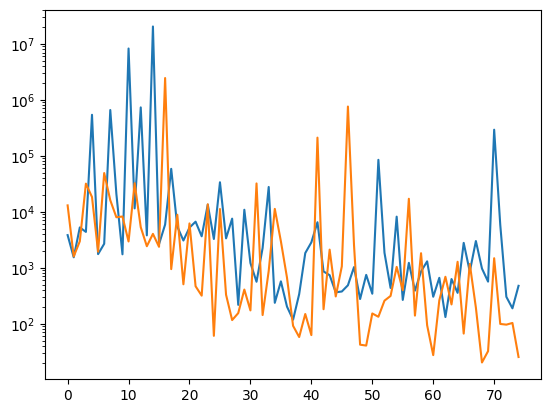

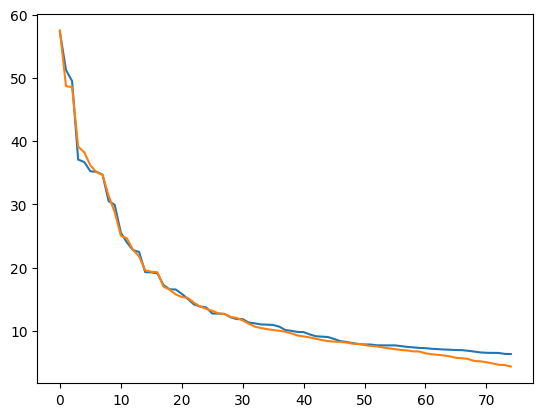

In [ ]:
e_ml, e_revd = zip(*err)
plt.plot(e_ml, label='ml')
plt.plot(e_revd, label='revd')
plt.yscale('log')
plt.figure()
plt.plot(np.sort(S_ex)[::-1])
plt.plot(W)